In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

path = os.getcwd()
file_path = os.path.join(path,"file")
sub_path = os.path.join(path,"제출")
sub_num = 33
train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))
weights_path = os.path.join(path,"save_weights")
if not os.path.isdir(weights_path):
    os.mkdir(weights_path)

In [2]:
from pytimekr import pytimekr
import datetime

List_holiday = []
for i in range(5,1523,7):
    List_holiday.append((datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d"))
    
for i in range(2019,2024):
    List_holiday.extend(pytimekr.holidays(year=i)) #리스트 형태로 반환

for i in range(len(List_holiday)):
    List_holiday[i] = str(List_holiday[i])
np.sort(List_holiday)

array(['2019-01-01', '2019-01-06', '2019-01-13', '2019-01-20',
       '2019-01-27', '2019-02-03', '2019-02-04', '2019-02-05',
       '2019-02-06', '2019-02-10', '2019-02-17', '2019-02-24',
       '2019-03-01', '2019-03-03', '2019-03-10', '2019-03-17',
       '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
       '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-05',
       '2019-05-12', '2019-05-12', '2019-05-19', '2019-05-26',
       '2019-06-02', '2019-06-06', '2019-06-09', '2019-06-16',
       '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
       '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
       '2019-08-15', '2019-08-18', '2019-08-25', '2019-09-01',
       '2019-09-08', '2019-09-12', '2019-09-13', '2019-09-14',
       '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-03',
       '2019-10-06', '2019-10-09', '2019-10-13', '2019-10-20',
       '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
       '2019-11-24', '2019-12-01', '2019-12-08', '2019-

In [3]:
Holiday_y_n = []
for i in range(0,1523):
    if (datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d") in List_holiday:
        Holiday_y_n.append(0)
    else:
        Holiday_y_n.append(1)

In [4]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

In [5]:
a = test_df['ID'].str.split("_")
I = ""
J = ""
K = ""
List_Test = []
for i,j,k,l in a:
    if I!=i or J!=j or K!=k:
        List_Test.append([i,j,k])
        I = i
        J = j
        K = k
    else:
        continue

In [6]:
List_i_c_l = []
for i in train_df['item'].unique():
    for j in train_df['corporation'].unique():
        for k in train_df['location'].unique():
            if train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:].shape[0]!=0:
                List_i_c_l.append([i,j,k])

In [7]:
List_i_c_l

[['TG', 'A', 'J'],
 ['TG', 'A', 'S'],
 ['TG', 'B', 'J'],
 ['TG', 'B', 'S'],
 ['TG', 'C', 'J'],
 ['TG', 'C', 'S'],
 ['TG', 'D', 'J'],
 ['TG', 'D', 'S'],
 ['TG', 'E', 'J'],
 ['TG', 'E', 'S'],
 ['CR', 'A', 'J'],
 ['CR', 'B', 'J'],
 ['CR', 'C', 'J'],
 ['CR', 'D', 'J'],
 ['CR', 'D', 'S'],
 ['CR', 'E', 'J'],
 ['CR', 'E', 'S'],
 ['CB', 'A', 'J'],
 ['CB', 'A', 'S'],
 ['CB', 'D', 'J'],
 ['CB', 'E', 'J'],
 ['CB', 'F', 'J'],
 ['RD', 'A', 'J'],
 ['RD', 'A', 'S'],
 ['RD', 'C', 'S'],
 ['RD', 'D', 'J'],
 ['RD', 'D', 'S'],
 ['RD', 'E', 'J'],
 ['RD', 'E', 'S'],
 ['RD', 'F', 'J'],
 ['BC', 'A', 'J'],
 ['BC', 'A', 'S'],
 ['BC', 'B', 'J'],
 ['BC', 'B', 'S'],
 ['BC', 'C', 'J'],
 ['BC', 'C', 'S'],
 ['BC', 'D', 'J'],
 ['BC', 'E', 'J'],
 ['BC', 'E', 'S']]

In [8]:
for i, j, k in List_i_c_l:
    globals()[f"train_{i}_{j}_{k}"]=train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:]
    globals()[f"train_{i}_{j}_{k}"].drop(columns=['ID', 'timestamp', 'corporation','location'])
    globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
    globals()[f"train_{i}_{j}_{k}"] = globals()[f"train_{i}_{j}_{k}"][['supply(kg)', 'year', 'month', 'day','Holiday', 'price(원/kg)']]
    globals()[f"train_ar_{i}_{j}_{k}"] = np.array(globals()[f"train_{i}_{j}_{k}"])
#     print(i,j,k,globals()[f"train_{i}_{j}_{k}"].shape)
#     display(globals()[f"train_{i}_{j}_{k}"].corr())

C:\Users\USER\AppData\Local\Temp\ipykernel_22236\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
C:\Users\USER\AppData\Local\Temp\ipykernel_22236\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
C:\Users\USER\AppData\Local\Temp\ipykernel_22236\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [9]:
def minmaxscaler(data):
    s_data = (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0))
    return s_data, np.min(data,axis=0), np.max(data,axis=0)

In [10]:
num = {"TG":10,"CR":7,"CB":5,"RD":8,"BC":9}
shape = globals()[f"train_ar_{i}_{j}_{k}"].shape
for i in train_df['item'].unique():
    globals()[f"train_x_concat_{i}"] = np.zeros((shape[0],num[i],shape[1]))
name = List_i_c_l[0][0]
n = 0
for i, j, k in List_i_c_l:
    if name != i :
        name=i
        n=0
    globals()[f"train_x_concat_{i}"][:,n,:] = globals()[f"train_ar_{i}_{j}_{k}"]
    n+=1
    globals()[f"train_minmax_{i}"],globals()[f"train_min_{i}"],globals()[f"train_max_{i}"] = minmaxscaler(globals()[f"train_x_concat_{i}"])

C:\Users\USER\AppData\Local\Temp\ipykernel_22236\313065710.py:2: RuntimeWarning: invalid value encountered in divide
  s_data = (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0))


In [11]:
def build_dataset(Training_data, seq_length, future_length):
    dataX = []
    dataY = []
    for i in range(0, Training_data.shape[0]-seq_length-future_length+1): 
        _x = Training_data[i:i+seq_length,:,:]
        _y = Training_data[i+seq_length:i+seq_length+future_length,:,-1] 
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [12]:
print(globals()[f"train_minmax_{i}"].shape)

(1523, 9, 6)


In [13]:
S_Length = 60
pred_Length = 28

for i in train_df['item'].unique():
    globals()[f"Train_x_{i}"], globals()[f"train_y_{i}"] = build_dataset(globals()[f"train_minmax_{i}"], S_Length, pred_Length)
    globals()[f"train_x_{i}"] = np.reshape(globals()[f"Train_x_{i}"],(globals()[f"Train_x_{i}"].shape[0],globals()[f"Train_x_{i}"].shape[1],-1))
    print(globals()[f"train_x_{i}"].shape, globals()[f"train_y_{i}"].shape)

(1436, 60, 60) (1436, 28, 10)
(1436, 60, 42) (1436, 28, 7)
(1436, 60, 30) (1436, 28, 5)
(1436, 60, 48) (1436, 28, 8)
(1436, 60, 54) (1436, 28, 9)


In [14]:
def rmse(y_true,y_pred):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.pow((y_true-y_pred),2)))

In [28]:
import tensorflow.keras.backend as K
def my_relu(x):
    return K.maximum(0.0, x)
def my_leaky_relu(x):
    alpha = 0.01
    return K.maximum(alpha*x, x)
def my_elu(x):
    # ELU 함수
    # alpha 값이 1외에 다른 값이면 SeLU가 된다.
    alpha = 1 
    return K.maximum(0., x) + K.maximum(0., -x) * (-1./(x+0.000001)) * alpha * (K.exp(x)-1)

# for i in train_df['item'].unique():
for i in ['CR']:
    #TG : 0.0005
    # CR : 0.0001
    # 나머지 : 0.001
    globals()[f"Model{i}"]=tf.keras.Sequential()
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=10, return_sequences = True, input_shape=(S_Length,globals()[f"train_x_{i}"].shape[2])))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=15,return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(lambda x: x[:, -28:, :]))
    globals()[f"Model{i}"].add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(20)))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=20,return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=20,return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=globals()[f"train_y_{i}"].shape[2],return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_relu))
    globals()[f"Model{i}"].compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.0001))
    globals()[f"Model{i}"].summary()
    globals()[f"Model{i}"].fit(globals()[f"train_x_{i}"], globals()[f"train_y_{i}"], epochs=3000)
    globals()[f"Model{i}"].save_weights(os.path.join(weights_path, i+"_weights"+str(sub_num)))

C:\Users\USER\anaconda3\envs\SU\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 60, 10)            2120      
_________________________________________________________________
lambda_49 (Lambda)           (None, 60, 10)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 60, 15)            1560      
_________________________________________________________________
lambda_50 (Lambda)           (None, 60, 15)            0         
_________________________________________________________________
lambda_51 (Lambda)           (None, 28, 15)            0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 28, 20)            320       
_________________________________________________________________
lambda_52 (Lambda)           (None, 28, 20)           

45/45 [==============================] - 0s 7ms/step - loss: 0.0169
Epoch 76/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0169
Epoch 77/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0169
Epoch 78/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 79/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 80/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 81/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 82/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 83/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 84/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 85/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 86/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 87/3000
45/45 [=========

45/45 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 175/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 176/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 177/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 178/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 179/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 180/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 181/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 182/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 183/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 184/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 185/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 186/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 273/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 274/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 275/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 276/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 277/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 278/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 279/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0152
Epoch 280/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 281/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 282/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 283/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0152
Epoch 284/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 371/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 372/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 373/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 374/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0146
Epoch 375/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 376/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 377/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 378/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 379/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0145
Epoch 380/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 381/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0145
Epoch 382/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 469/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 470/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 471/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0141
Epoch 472/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 473/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 474/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 475/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 476/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 477/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 478/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 479/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 480/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0139
Epoch 567/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0139
Epoch 568/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 569/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0139
Epoch 570/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0139
Epoch 571/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 572/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 573/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 574/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 575/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 576/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 577/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 578/3000
45/4

45/45 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 665/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 666/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 667/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 668/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 669/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 670/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 671/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 672/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 673/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 674/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0135
Epoch 675/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0134
Epoch 676/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0132
Epoch 763/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 764/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 765/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 766/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 767/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 768/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 769/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 770/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 771/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 772/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0128
Epoch 773/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 774/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 861/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 862/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 863/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 864/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 865/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 866/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 867/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 868/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 869/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 870/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 871/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 872/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 959/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 960/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 961/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0110
Epoch 962/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 963/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 964/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 965/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 966/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 967/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 968/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0109
Epoch 969/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 970/3000
45/4

45/45 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 1057/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 1058/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 1059/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 1060/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 1061/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 1062/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 1063/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 1064/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 1065/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 1066/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 1067/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 10

45/45 [==============================] - 0s 8ms/step - loss: 0.0078
Epoch 1154/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 1155/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 1156/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 1157/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0078
Epoch 1158/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 1159/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0078
Epoch 1160/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 1161/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 1162/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 1163/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 1164/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0077
Epoch 11

45/45 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 1251/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 1252/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 1253/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 1254/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 1255/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 1256/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 1257/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 1258/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 1259/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 1260/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 1261/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 12

45/45 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 1348/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 1349/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 1350/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 1351/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 1352/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 1353/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 1354/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 1355/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 1356/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 1357/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 1358/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 13

45/45 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 1445/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 1446/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 1447/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 1448/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 1449/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 1450/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 1451/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 1452/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 1453/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 1454/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 1455/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 14

45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1542/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1543/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1544/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1545/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1546/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 1547/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1548/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1549/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1550/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1551/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1552/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 15

45/45 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 1639/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 1640/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 1641/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 1642/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 1643/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 1644/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 1645/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 1646/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 1647/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 1648/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 1649/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 16

45/45 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 1736/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 1737/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 1738/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 1739/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 1740/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 1741/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 1742/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 1743/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 1744/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 1745/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 1746/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 17

45/45 [==============================] - 0s 8ms/step - loss: 0.0046
Epoch 1833/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 1834/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 1835/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 1836/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 1837/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 1838/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 1839/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 1840/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 1841/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 1842/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 1843/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 18

45/45 [==============================] - 0s 8ms/step - loss: 0.0046
Epoch 1930/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1931/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1932/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1933/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1934/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1935/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1936/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1937/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 1938/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 1939/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 1940/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 19

45/45 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 2027/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 2028/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 2029/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 2030/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 2031/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 2032/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 2033/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 2034/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0040
Epoch 2035/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0040
Epoch 2036/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0040
Epoch 2037/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0040
Epoch 20

45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2124/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 2125/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2126/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2127/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2128/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 2129/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2130/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2131/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2132/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2133/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 2134/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 21

45/45 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 2221/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 2222/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 2223/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 2224/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 2225/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 2226/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 2227/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 2228/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 2229/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 2230/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 2231/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 22

45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2318/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2319/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2320/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2321/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2322/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2323/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2324/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2325/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 2326/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2327/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 2328/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 23

45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2415/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2416/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2417/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2418/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2419/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 2420/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2421/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2422/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2423/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 2424/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 2425/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 24

45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2512/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2513/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2514/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 2515/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2516/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 2517/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2518/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2519/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2520/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2521/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 2522/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 25

45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2609/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2610/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2611/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2612/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2613/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2614/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2615/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2616/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2617/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2618/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2619/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 26

45/45 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 2706/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 2707/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2708/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 2709/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 2710/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 2711/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 2712/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 2713/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0081
Epoch 2714/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0074
Epoch 2715/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 2716/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 27

45/45 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 2803/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2804/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 2805/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2806/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2807/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 2808/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2809/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2810/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2811/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2812/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 2813/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 28

45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2900/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2901/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2902/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2903/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2904/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2905/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2906/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2907/3000
45/45 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 2908/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2909/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 2910/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 29

45/45 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 2997/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 2998/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 2999/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 3000/3000
45/45 [==============================] - 0s 7ms/step - loss: 0.0025


In [35]:
preds = np.zeros((0,1))
for i in train_df['item'].unique():
    print(i)
    predict = np.reshape(globals()[f"train_minmax_{i}"][-S_Length:,:,:],(1,S_Length,-1))
    globals()[f"Model{i}"].load_weights(os.path.join(weights_path, i+"_weights"+str(sub_num)))
    globals()[f"Predict{i}"] = globals()[f"Model{i}"].predict(predict)
    globals()[f"Predict_re{i}"] = (globals()[f"Predict{i}"]*(globals()[f"train_max_{i}"][:,-1] - globals()[f"train_min_{i}"][:,-1]) + globals()[f"train_min_{i}"][:,-1])[0]
    print(globals()[f"Predict_re{i}"].shape)
    globals()[f"Predict_Re{i}"] = np.reshape(np.transpose(globals()[f"Predict_re{i}"]),-1)
    globals()[f"Predict_Re{i}"][np.where((globals()[f"Predict_Re{i}"]<=0))[0]] = 0
    preds = np.vstack((preds,np.expand_dims(globals()[f"Predict_Re{i}"],axis = -1)))
    print(globals()[f"Predict_Re{i}"].shape)

TG
(28, 10)
(280,)
CR
(28, 7)
(196,)
CB
(28, 5)
(140,)
RD
(28, 8)
(224,)
BC
(28, 9)
(252,)


In [36]:
submission = pd.read_csv(os.path.join(file_path,"sample_submission.csv"))
submission


,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [37]:
holiday_test = ["20230305","20230312","20230319","20230326"]
submission['answer'] = preds
submission.loc[submission['ID'].str.split("_").str[3].isin(holiday_test),"answer"] = 0
display(submission.head(20))
display(submission.tail(20))

,ID,answer
0,TG_A_J_20230304,3162.709428
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,3491.306665
3,TG_A_J_20230307,3913.039741
4,TG_A_J_20230308,4224.499771
5,TG_A_J_20230309,6261.023617
6,TG_A_J_20230310,6316.255015
7,TG_A_J_20230311,5587.221076
8,TG_A_J_20230312,0.000000
9,TG_A_J_20230313,24.930958


,ID,answer
1072,RD_F_J_20230312,0.000000
1073,RD_F_J_20230313,2232.811287
1074,RD_F_J_20230314,2262.226962
1075,RD_F_J_20230315,2169.465344
1076,RD_F_J_20230316,2087.103579
1077,RD_F_J_20230317,1864.801515
1078,RD_F_J_20230318,1973.687075
1079,RD_F_J_20230319,0.000000
1080,RD_F_J_20230320,2132.794596
1081,RD_F_J_20230321,1885.375287


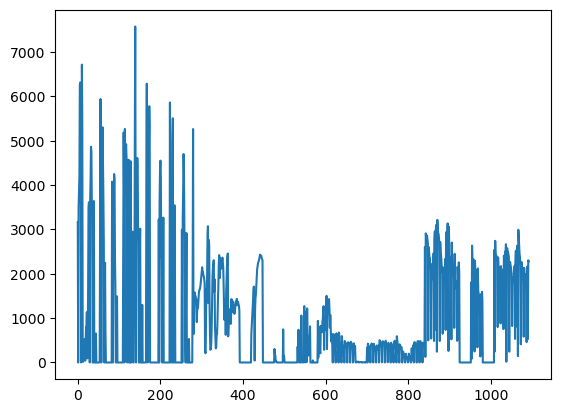

In [38]:
import matplotlib.pyplot as plt
plt.plot(preds)
plt.show()

In [39]:
submission.to_csv(os.path.join(sub_path,f"baseline_submission{sub_num}.csv"), index=False)

In [40]:
submission['answer'].isna().sum()

0